In [ ]:
!pip install maticalgos
!pip install py_vollib

For data scraping

In [ ]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.greeks.analytical import delta, gamma, theta, vega
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import requests
import json
import math
from zoneinfo import ZoneInfo
from tqdm import tqdm

def calculate_greeks(nifty_price, strike, strikePrice, expiryDate, test_current=""):
    flag = ""
    if(strike[-2:] == "CE"):   flag = 'c'
    else:                      flag = 'p'

    S = nifty_price
    K = int(strike[0:5])
    r = 0.1

    expiry = expiryDate.split('-')
    year = int(expiry[0])
    month = int(expiry[1])
    day = int(expiry[2])

    t = 0
    if(test_current != ""):
        # here we need to implement the algorithm
        test_current = test_current.split(' ')
        date_format = test_current[0].split('-')
        time_format = test_current[1].split(':')
        # print(int(time_format[0]))

        t = ((datetime(year, month, day, 15, 30, 0) - datetime(int(date_format[0]), int(date_format[1]), int(date_format[2]), int(time_format[0]), int(time_format[1]), int(time_format[2])))/timedelta(days=1))/365
    else:
        t = ((datetime(year, month, day, 15, 30, 0) - datetime.now())/timedelta(days=1))/365

    if(flag == 'c'):
        price = strikePrice

        IV = implied_volatility(price, S, K, t, r, flag)
        Delta =  delta(flag, S, K, t, r, IV)
        Gamma = gamma(flag, S, K, t, r, IV)
        Vega = vega(flag, S, K, t, r, IV)

        return [IV, Delta, Gamma, Vega]


    else:
        price = strikePrice

        IV = implied_volatility(price, S, K, t, r, flag)
        Delta =  delta(flag, S, K, t, r, IV)
        Gamma = gamma(flag, S, K, t, r, IV)
        Vega = vega(flag, S, K, t, r, IV)

        return [IV, Delta, Gamma, Vega]

In [ ]:
from maticalgos.historical import historical
from datetime import datetime, timedelta, date

password = '#######'
ma = historical('om21481@iiitd.ac.in')
ma.login(password)

In [ ]:
months = {'JAN': 1,'FEB': 2,'MAR': 3,'APR':4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

def cal_greeks(row, curr_date, nifty_price, expiry):
  data_strike = row['symbol'][12:]
  strike_price_data = float(row['close'])
  curr_date_data = curr_date + " " + row['time']
  curr_nifty_price = float(nifty_price[nifty_price['time'] == row['time']]['close'].values[0])

  try:
    result = calculate_greeks(curr_nifty_price, data_strike, strike_price_data, expiry, curr_date_data)
    return pd.Series({'IV': result[0], 'Delta': result[1], 'Gamma': result[2], 'Vega': result[3]})
  except:
    return pd.Series({'IV': np.nan, 'Delta': np.nan, 'Gamma': np.nan, 'Vega': np.nan})

def main_fun(curr_date, time_str):
  year = int(curr_date.split('-')[0])
  month = int(curr_date.split('-')[1])
  day = int(curr_date.split('-')[2])

  min_data = ma.get_data("nifty", date(year,month,day))

  # ------------------------------------------------------------------------------------------------------------------------------------------------

  strike = sorted(min_data['symbol'].unique())[2]

  expiry_day = strike[slice(5, 7)]
  expiry_month = months[strike[slice(7, 10)]]
  expiry_yr = str(2000 + int(strike[slice(10, 12)]))

  if(expiry_month < 10):
    expiry_month = "0" + str(expiry_month)
  else:
    expiry_month = str(expiry_month)

  expiry = expiry_yr + "-" + expiry_month + "-" + expiry_day
  # print(expiry)

  format_str = "%H:%M:%S"

  current_time = datetime.strptime(time_str, format_str)
  current_time = current_time - timedelta(minutes=5)
  ini_time = current_time - timedelta(minutes=16)

  min_data['time'] = pd.to_datetime(min_data['time'], format = format_str)

  min_data = min_data[(min_data['time'] >= ini_time) & (min_data['time'] <= current_time)]
  min_data['time'] = min_data['time'].dt.strftime(format_str)

  nifty_price = min_data[min_data['symbol'] == 'NIFTY']
  nifty_price = nifty_price.drop(columns=['volume', 'oi']);
  nifty_price = nifty_price.reset_index()

  nifty_futures = min_data[min_data['symbol'] == 'NIFTY-I']
  nifty_futures = nifty_futures.reset_index()

  min_data = min_data[~min_data['symbol'].isin(['NIFTY', 'NIFTY-I'])]
  min_data = min_data.reset_index()


  nifty_futures['close'] = pd.to_numeric(nifty_futures['close'], errors='coerce')
  nifty_futures['volume'] = pd.to_numeric(nifty_futures['volume'], errors='coerce')
  nifty_futures['oi'] = pd.to_numeric(nifty_futures['oi'], errors='coerce')

  nifty_futures['fut_close_change'] = nifty_futures['close'].diff()
  nifty_futures['fut_volume_change'] = nifty_futures['volume'].diff()

  nifty_futures['fut_oi_change'] = nifty_futures['oi'].diff(periods=3)
  nifty_futures = nifty_futures[['fut_close_change', 'fut_volume_change', 'fut_oi_change']]
  nifty_futures.loc[nifty_futures.index % 3 != 0, 'fut_oi_change'] = np.nan

  nifty_price['close'] = pd.to_numeric(nifty_price['close'], errors='coerce')

  nifty_price['nifty_close_change'] = nifty_price['close'].diff()
  nifty_price = nifty_price.reset_index()

  result_df = pd.concat([nifty_price, nifty_futures], axis=1)
  result_df = result_df[['nifty_close_change', 'fut_close_change', 'fut_volume_change', 'fut_oi_change']]

  new_columns = [f"{col}.{i}" for col in result_df.columns for i in range(0, result_df.shape[0])]
  new_values = np.concatenate([result_df[col].values[:, np.newaxis] for col in result_df.columns], axis=0)
  result_df = pd.DataFrame([new_values.flatten()], columns=new_columns)      # ---------------------------------------------------------


  greeks_df = min_data.copy()
  greeks_df[['IV', 'Delta', 'Gamma', 'Vega']] = greeks_df.apply(cal_greeks, axis=1, args=(curr_date, nifty_price, expiry))
  greeks_df.dropna(inplace=True)

  greeks_df['oi'] = pd.to_numeric(greeks_df['oi'], errors='coerce')
  greeks_df['close'] = pd.to_numeric(greeks_df['close'], errors='coerce')
  greeks_df['volume'] = pd.to_numeric(greeks_df['volume'], errors='coerce')

  greeks_df['option_type'] = greeks_df['symbol'].str[-2:]
  greeks_df['option_type'] = greeks_df['option_type'].str.upper()

  atm_df = nifty_price.copy()
  atm_df = atm_df[['close', 'time']]
  atm_df['ATM_strike'] = (atm_df['close'] // 100) * 100
  atm_df = atm_df[['ATM_strike', 'time']]
  greeks_df = pd.merge(greeks_df, atm_df, on=['time'], how='inner')



  summarized_greeks_df = greeks_df.groupby(['time', 'option_type']).agg({'volume': 'sum', 'oi': 'sum'}).unstack().reset_index()

  summarized_greeks_df.columns = ['time', 'volume_CE', 'volume_PE', 'OI_CE', 'OI_PE']
  summarized_greeks_df['pcr_volume'] = summarized_greeks_df['volume_PE'] / summarized_greeks_df['volume_CE']
  summarized_greeks_df['pcr_oi'] = summarized_greeks_df['OI_PE'] / summarized_greeks_df['OI_CE']

  summarized_greeks_df['volume_CE_chng'] = summarized_greeks_df['volume_CE'].diff()
  summarized_greeks_df['volume_PE_chng'] = summarized_greeks_df['volume_PE'].diff()
  summarized_greeks_df['OI_CE_chng'] = summarized_greeks_df['OI_CE'].diff()
  summarized_greeks_df['OI_PE_chng'] = summarized_greeks_df['OI_PE'].diff()

  summarized_greeks_df = summarized_greeks_df[['volume_CE_chng', 'volume_PE_chng', 'OI_CE_chng', 'OI_PE_chng', 'pcr_volume', 'pcr_oi']]

  new_columns = [f"{col}.{i}" for col in summarized_greeks_df.columns for i in range(0, summarized_greeks_df.shape[0])]
  new_values = np.concatenate([summarized_greeks_df[col].values[:, np.newaxis] for col in summarized_greeks_df.columns], axis=0)
  summarized_greeks_df = pd.DataFrame([new_values.flatten()], columns=new_columns)       # ---------------------------------------------------------


  # atm_df = greeks_df[(greeks_df['ATM_strike'] == greeks_df['symbol'].str[-7:-2].astype(float))][['time', 'IV', 'Vega', 'option_type']]
  # atm_df = atm_df.groupby(['time', 'option_type']).agg({'Vega': 'sum'}).unstack().reset_index()
  # atm_df.columns = ['time', 'Vega_CE', 'Vega_PE']

  # atm_df['Vega_ATM_CE_chng'] = atm_df['Vega_CE'].diff()
  # atm_df['Vega_ATM_PE_chng'] = atm_df['Vega_PE'].diff()

  # atm_df = atm_df[['Vega_ATM_CE_chng', 'Vega_ATM_PE_chng']]

  # new_columns = [f"{col}.{i}" for col in atm_df.columns for i in range(0, atm_df.shape[0])]
  # new_values = np.concatenate([atm_df[col].values[:, np.newaxis] for col in atm_df.columns], axis=0)
  # atm_df = pd.DataFrame([new_values.flatten()], columns=new_columns)          # ---------------------------------------------------------


  otm_df = greeks_df[((greeks_df['ATM_strike'] >= greeks_df['symbol'].str[-7:-2].astype(float)) & (greeks_df['option_type'] == "CE")) | ((greeks_df['ATM_strike'] <= greeks_df['symbol'].str[-7:-2].astype(float)) & (greeks_df['option_type'] == "PE"))]
  otm_df = otm_df[['time', 'Vega', 'option_type']]
  otm_df = otm_df.groupby(['time', 'option_type']).agg({'Vega': 'sum'}).unstack().reset_index()

  otm_df.columns = ['time', 'Vega_CE', 'Vega_PE']
  otm_df['Vega_CE_chng'] = otm_df['Vega_CE'].diff()
  otm_df['Vega_PE_chng'] = otm_df['Vega_PE'].diff()

  otm_df = otm_df[['Vega_CE_chng', 'Vega_PE_chng']]

  new_columns = [f"{col}.{i}" for col in otm_df.columns for i in range(0, otm_df.shape[0])]
  new_values = np.concatenate([otm_df[col].values[:, np.newaxis] for col in otm_df.columns], axis=0)
  otm_df = pd.DataFrame([new_values.flatten()], columns=new_columns)      # ---------------------------------------------------------

  keys = ['result_df', 'otm_df', 'atm_df', 'summarized_greeks_df']


  temp = pd.concat([result_df, otm_df, summarized_greeks_df], axis=1, keys=keys)

  temp['date'] = curr_date
  temp['expiry'] = expiry
  temp['time'] = time_str

  return temp

In [ ]:
import pandas as pd
import numpy as np 

X = pd.DataFrame()

DL_data = pd.read_csv("DATA_NIFTY50_DLmodel.csv")

y = []

indexes_to_remove = []

def is_thursday(date_str):
    date_object = datetime.strptime(date_str, '%Y-%m-%d')
    return date_object.weekday() == 3

for row in tqdm(range(0, len(DL_data))):
    curr_date = "-".join(DL_data.iloc[row]['DATE'].split("-")[::-1])
    
    if(not(is_thursday(curr_date))):
        try:
            X = pd.concat([X, main_fun(curr_date, DL_data.iloc[row]['TIME'])], axis=0)
            y.append(DL_data.iloc[row]['SIDE'])
        except:
            indexes_to_remove.append(row)

X.to_csv('DL_DATA_greeks_new.csv')
print(y)

print("The Indexes to remove are:")
print(indexes_to_remove)

In [ ]:
indexes = [30, 63, 76, 143, 147, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 196, 204, 205, 206, 217, 262, 325]

y = ["labels", 1, 2, 1, -1, 0, 1, 1, -2, 2, 2, 0, -2, 2, -2, 2, 2, 2, -2, -1, 0, -1, 2, -1, 1, -2, -2, -2, -2, -2, 1, 1, -1, 0, 1, -1, 1, -1, 1, -2, -1, -1, 0, 1, 0, -2, -1, 0, 1, -1, 0, 0, -1, 1, 1, 0, -1, 0, -2, -2, -1, 0, 0, 1, 0, -2, 1, 1, 1, -1, 2, 1, -2, -2, 2, -2, 0, 0, 1, -2, -1, 2, 1, 0, 1, 0, -1, 1, -1, -2, 2, -1, -2, 0, 2, 0, -1, 0, 0, 0, 2, 1, -2, 2, 1, 0, 2, 1, 0, 2, -1, 0, 0, 2, 0, -1, 1, -2, 1, 0, 0, 2, -1, 0, -1, 2, 1, -2, 0, 2, 1, -1, -1, -2, -1, 0, 0, 2, 1, 0, 1, -2, 1, 0, -2, -2, 2, 0, 2, 0, 0, -1, -1, 0, -2, 0, 0, 2, 1, -2, 2, 0, 2, -2, 0, 0, 2, 0, 0, 1, -2, -1, -1, 1, 1, 0, 0, -1, 2, 0, 0, 0, 2, -2, 1, 1, -1, 0, 0, 2, 1, 2, 1, -2, 0, 1, 0, 0, 0, -2, 2, -2, 2, 2, 0, 2, 0, 0, 2, -1, -1, -1, 1, -2, -2, 0, -1, -2, -2, 1, 2, 0, -1, -2, 2, 2, -2, 2, 2, 2, -1, -2, 0, 1, 0, -1, -2, 2, 2, -1, 1, 0, -2, 1, 0, 1, -1, 0, 2, -1, 0, 1, 1, 0, -1, -2, -1, 1, -2, 2, 1, -2, 2, 0, 1, 0, 0, 0, -1, -2, 2, 1, 0, -2, 2, 1, 2, 0, -1, 2, 2, 0, 0, 2, 2, -1, 1, 2, 1, 0, -1, -2, 1, -1, 1, 0, 0, 2, -1, -2, 1, -1, -1, -2, 1, 1, -1, 0, 2, 1, -1, -2, 1, -2, -1, 1, 1, -2, -1, 1, 2, 1, -2, 0, 2, 2, 2, -2, 1, 2, -2, 2, 2, 2, 0, -2, -1, 1, 0, 2, 2, 2, 0, 1, -2, -1, -1, 1, -2, 0, 0, 2, 2, 0, 2, 2, 0, -2, -1, -2, -1, -2, -2, -1, -2, 0, 1, -2, -2, -2, 1, -1, 2, -2, 2, -2, 0, 2, 1, 1, 1, 0, -2, -2, 2, 0, 2, -1, -1, 1, -1, 0, 2, 0, 2, 1, 0, 0, 1, -2, 2, -1, -1, 2, 0, 0, 0, 2, -1, 2, 1, 2, 2, -2, -1, -1, -2, 2, 0, 0, 1, 0, 1, 1, 0, 1, 2, -2, 1, -2, 0, 0, 0, -2, -2, -1, 2, 0, -1, -2, 0, 0, 2, 2, 1, 2, 2, 0, 0, 1, 0, 0, -2, 0, -1, 2, 2, 0, 1, -1, 2, 2, 1, -1, -1, 1, -1, -2, 0, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1, -1, 2, 1]

print(len(y))

Should be run from here

DL Model Training

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('DL_DATA_labels - DL_DATA_labels.csv')

X = data.iloc[:, :-4][1:]

y = data['labels'][1:]

In [5]:
import numpy as np 
import pandas as pd 

data = pd.read_csv('DL_DATA_labels - DL_DATA_labels.csv')
data.columns = data.iloc[0]
data = data.drop(data.index[0])

y = data['labels']
data = data.drop(columns=['date', 'expiry', 'time', 'labels'])

data = data.astype('float32')
data = data.fillna(0)

col_names = []
for i in data.columns:
    if("CE" in i):
        col_names.append(i)

for i in range(len(col_names)):
    CE_name = col_names[i]
    PE_name = "PE".join(CE_name.split("CE"))
    COL_name = CE_name + " - " + PE_name
    print(CE_name, PE_name)
    data[COL_name] = data[CE_name] - data[PE_name]

print(data.columns)

X = data

Vega_CE_chng.1 Vega_PE_chng.1
Vega_CE_chng.2 Vega_PE_chng.2
Vega_CE_chng.3 Vega_PE_chng.3
Vega_CE_chng.4 Vega_PE_chng.4
Vega_CE_chng.5 Vega_PE_chng.5
Vega_CE_chng.6 Vega_PE_chng.6
Vega_CE_chng.7 Vega_PE_chng.7
Vega_CE_chng.8 Vega_PE_chng.8
Vega_CE_chng.9 Vega_PE_chng.9
Vega_CE_chng.10 Vega_PE_chng.10
Vega_CE_chng.11 Vega_PE_chng.11
Vega_CE_chng.12 Vega_PE_chng.12
Vega_CE_chng.13 Vega_PE_chng.13
Vega_CE_chng.14 Vega_PE_chng.14
Vega_CE_chng.15 Vega_PE_chng.15
Vega_CE_chng.16 Vega_PE_chng.16
Vega_ATM_CE_chng.1 Vega_ATM_PE_chng.1
Vega_ATM_CE_chng.2 Vega_ATM_PE_chng.2
Vega_ATM_CE_chng.3 Vega_ATM_PE_chng.3
Vega_ATM_CE_chng.4 Vega_ATM_PE_chng.4
Vega_ATM_CE_chng.5 Vega_ATM_PE_chng.5
Vega_ATM_CE_chng.6 Vega_ATM_PE_chng.6
Vega_ATM_CE_chng.7 Vega_ATM_PE_chng.7
Vega_ATM_CE_chng.8 Vega_ATM_PE_chng.8
Vega_ATM_CE_chng.9 Vega_ATM_PE_chng.9
Vega_ATM_CE_chng.10 Vega_ATM_PE_chng.10
Vega_ATM_CE_chng.11 Vega_ATM_PE_chng.11
Vega_ATM_CE_chng.12 Vega_ATM_PE_chng.12
Vega_ATM_CE_chng.13 Vega_ATM_PE_chng.13
Vega

In [6]:
# 1, -1 -- represents the direction and there was a slow momentum
# 2, -2 -- represents the direction and there was a fast momentum
# 0     -- represents that there was no momentum

# when there is a momentum market always moves in one direction without disguising
# So we trained the model according to binary classification

y[y == '1'] = '0'
y[y == '2'] = '1'
y[y == '-1'] = '0'
y[y == '-2'] = '1'
y = y.astype('int')
print(y.value_counts())
print(y)

labels
0    297
1    186
Name: count, dtype: int64
1      0
2      1
3      0
4      0
5      0
      ..
479    0
480    0
481    0
482    1
483    0
Name: labels, Length: 483, dtype: int64


In [7]:
# Applying SMOTE to remove data imbalance 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_resampled.value_counts())

labels
0    267
1    167
Name: count, dtype: int64
labels
0    267
1    267
Name: count, dtype: int64


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(X_resampled.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))  
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_resampled, y_resampled, epochs=200, batch_size=32, validation_split=0.1)

Epoch 1/200
15/15 [==============================] - 1s 13ms/step - loss: 0.7021 - accuracy: 0.5042 - val_loss: 0.8022 - val_accuracy: 0.0000e+00
Epoch 2/200
15/15 [==============================] - 0s 4ms/step - loss: 0.7019 - accuracy: 0.5479 - val_loss: 0.8755 - val_accuracy: 0.0000e+00
Epoch 3/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5562 - val_loss: 0.8081 - val_accuracy: 0.0000e+00
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5562 - val_loss: 0.7961 - val_accuracy: 0.0000e+00
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5562 - val_loss: 0.7782 - val_accuracy: 0.0000e+00
Epoch 6/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.4938 - val_loss: 0.8410 - val_accuracy: 0.0000e+00
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.5562 - val_loss: 0.8196 - val_accur

2/2 [==============================] - 0s 2ms/step


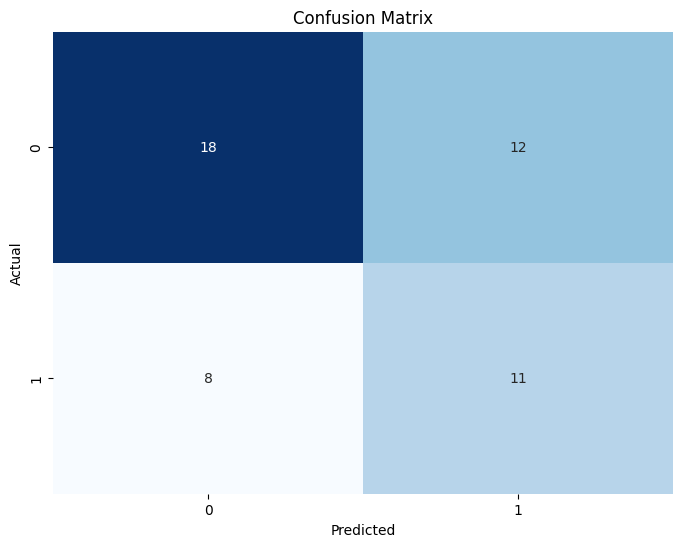

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns

# Assuming y_test is your true labels
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


16/16 [==============================] - 0s 2ms/step


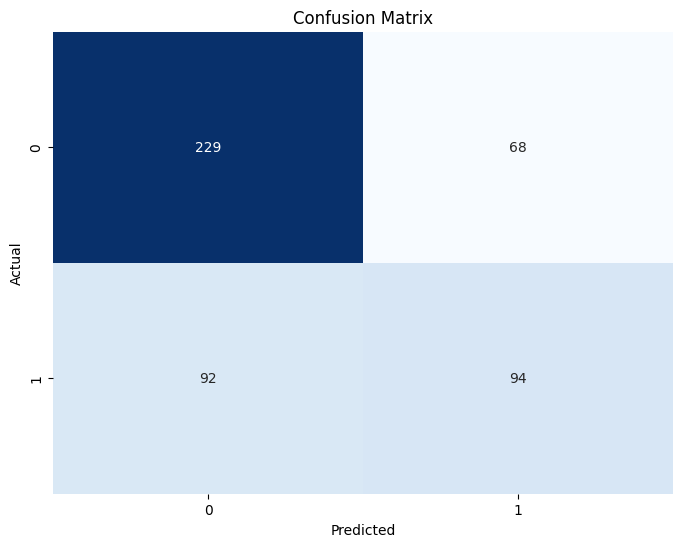

In [10]:

y_pred_probabilities = model.predict(X)
y_pred = np.argmax(y_pred_probabilities, axis=1)

conf_matrix = confusion_matrix(y, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Using PCA 

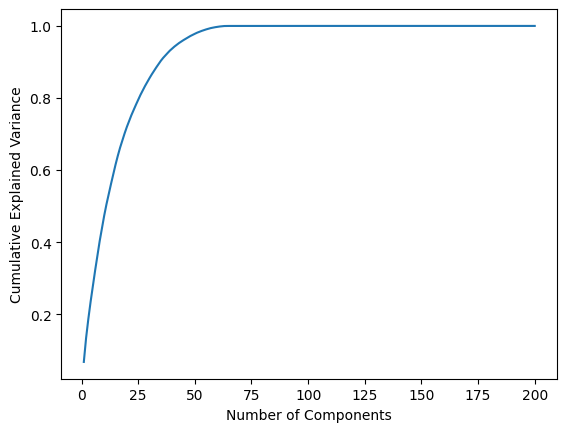

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [12]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_95 = np.argmax(cumulative_variance >= 0.99) + 1
print("Number of components for 95% variance:", num_components_95)


Number of components for 95% variance: 55


In [13]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = pd.DataFrame(X)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=65)  # Set the number of components you want
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
X = pd.DataFrame(data=principal_components)

# Print the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.07031591 0.03659293 0.02773747 0.02546515 0.02350677 0.02202399
 0.0209784  0.01967548 0.01940514 0.01821256 0.0178163  0.01657346
 0.01597926 0.01541643 0.01526434 0.0146107  0.0140709  0.01367122
 0.01337844 0.01296404 0.01258507 0.01226147 0.01186061 0.01173665
 0.01161197 0.01123987 0.01074486 0.01045377 0.01038836 0.01025948
 0.00996392 0.00975585 0.00934751 0.00922734 0.00909986 0.00881721
 0.00879515 0.0085349  0.00826643 0.00817281 0.00803307 0.00785711
 0.00759239 0.00749831 0.0073966  0.00720985 0.00713286 0.0068505
 0.00679652 0.00664997 0.00652806 0.00648184 0.00626887 0.00603012
 0.00590697 0.00584666 0.00569152 0.005671   0.00563117 0.00550682
 0.00537331 0.00516944 0.00512136 0.00501779 0.00492097]


In [14]:
# Applying SMOTE to remove data imbalance 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(y_train.value_counts())
print(y_resampled.value_counts())

labels
0    267
1    167
Name: count, dtype: int64
labels
0    267
1    267
Name: count, dtype: int64


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(X_resampled.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))  
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_resampled, y_resampled, epochs=150, batch_size=32, validation_split=0.1)

Epoch 1/150
15/15 [==============================] - 1s 11ms/step - loss: 0.6944 - accuracy: 0.5167 - val_loss: 0.8710 - val_accuracy: 0.0000e+00
Epoch 2/150
15/15 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5292 - val_loss: 1.1016 - val_accuracy: 0.0000e+00
Epoch 3/150
15/15 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.5437 - val_loss: 0.8958 - val_accuracy: 0.0000e+00
Epoch 4/150
15/15 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5354 - val_loss: 0.6827 - val_accuracy: 1.0000
Epoch 5/150
15/15 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5562 - val_loss: 0.9281 - val_accuracy: 0.0000e+00
Epoch 6/150
15/15 [==============================] - 0s 6ms/step - loss: 0.6863 - accuracy: 0.5562 - val_loss: 0.7782 - val_accuracy: 0.0000e+00
Epoch 7/150
15/15 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5375 - val_loss: 0.7627 - val_accuracy:

In [33]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

2/2 [==============================] - 0s 2ms/step - loss: 2.9599 - accuracy: 0.5714
Test accuracy: 0.5714285969734192


2/2 [==============================] - 0s 2ms/step


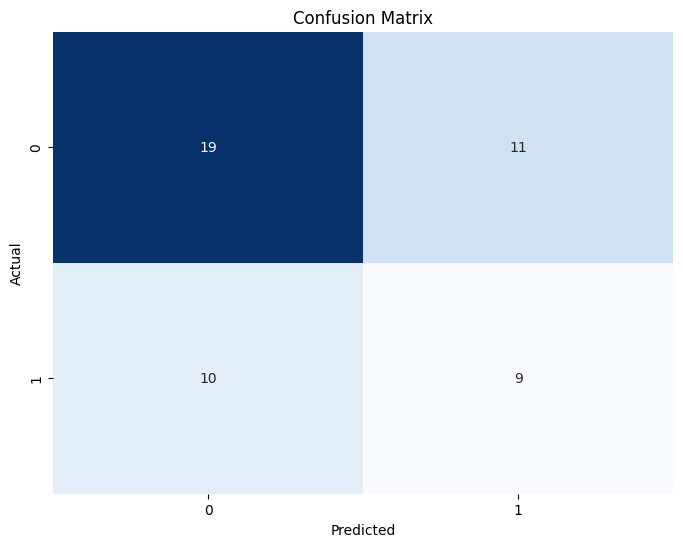

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns

# Assuming y_test is your true labels
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


16/16 [==============================] - 0s 867us/step


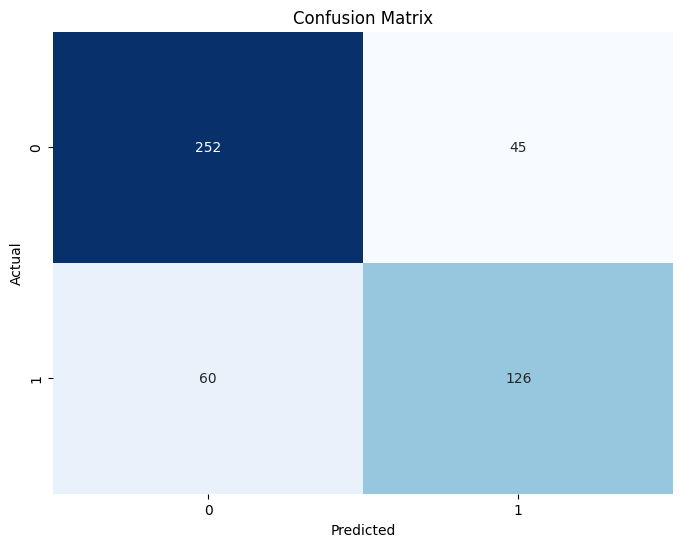

In [35]:

y_pred_probabilities = model.predict(X)
y_pred = np.argmax(y_pred_probabilities, axis=1)

conf_matrix = confusion_matrix(y, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()